# Computational Economics: Problem Set 5

This notebook solves both **Exercise 1** (deterministic income) and **Exercise 2** (stochastic income) of the life‐cycle model.  
We will:

1. **Define parameters** and survival probabilities ξ(s).  
2. **Plot** ξ(s).  
3. **Solve** by value‐function iteration.  
4. **Simulate** and **plot** life‐cycle paths for 10 individuals.  


## 1. Imports and Common Parameters


In [9]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from numba import njit      # for speed, optional
from scipy.stats import norm

In [10]:
# %%
# Time
s_start = 1             # age index at 25
T_work = 40             # working periods
T_max = 75              # max age index
S = T_max

# Preferences & returns
σ = 1.5
β = 0.98
r = 0.03

# Retirement benefit
b = 0.9

# Asset grid
A_min, A_max = 0.0, 50.0
nA = 500
agrid = np.linspace(A_min, A_max, nA)


In [11]:
# %%
# Time
s_start = 1             # age index at 25
T_work = 40             # working periods
T_max = 75              # max age index
S = T_max

# Preferences & returns
σ = 1.5
β = 0.98
r = 0.03

# Retirement benefit
b = 0.9

# Asset grid
A_min, A_max = 0.0, 50.0
nA = 500
agrid = np.linspace(A_min, A_max, nA)

## 2. Survival Probabilities ξ(s)

Define and plot  
$$
\xi(s)=
\begin{cases}
0, & 1\le s\le40,\\
\frac1{60}+\bigl(\tfrac{s-40}{52}\bigr)^3, & 41\le s\le74,\\
1, & s=75.
\end{cases}
$$


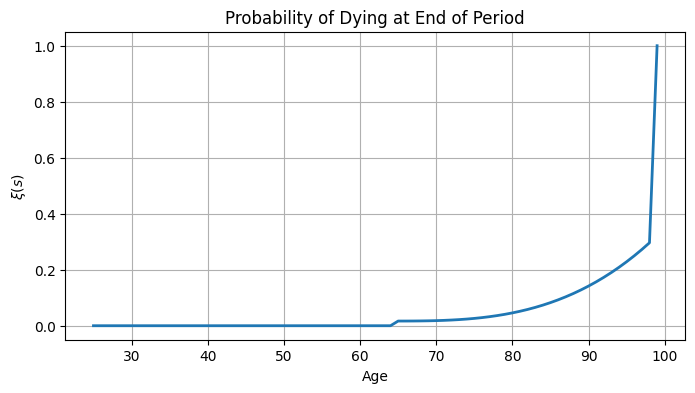

In [12]:
# %%
def xi(s):
    if s <= 40:
        return 0.0
    elif s < 75:
        return 1/60 + ((s-40)/52)**3
    else:
        return 1.0

# vectorize and plot
s_grid = np.arange(s_start, S+1)
xi_vec = np.array([xi(s) for s in s_grid])

plt.figure(figsize=(8,4))
plt.plot(s_grid+24, xi_vec, lw=2)   # age = s+24
plt.xlabel("Age")
plt.ylabel(r"$\xi(s)$")
plt.title("Probability of Dying at End of Period")
plt.grid(True)
plt.show()


## 3. Utility and Bellman Operator

We use CRRA utility  
$$
u(c)=\frac{c^{1-\sigma}-1}{1-\sigma},
$$  
and the budget constraint  
$$
c_t + a_{t+1} = z_t + (1+r)\,a_t,
$$
with $z_t=1$ in working life and $0$ in retirement (plus $b$).


In [13]:
# %%
@njit
def u(c):
    return (c**(1-σ)-1)/(1-σ) if c>0 else -1e10


## 4. Exercise 1: Deterministic Income

### 4.1. Value‐Function Iteration

State = (age s, assets a).  Income zₜ=1 for s≤40, zₜ=0+ b for s>40.


In [14]:
# %%
# Precompute income by age:
z = np.zeros(S+1)
z[1:T_work+1] = 1.0
z[T_work+1:]   = b

# Terminal value: must consume all assets
V_next = np.array([u((1+r)*a + z[S]) for a in agrid])

# storage
policy_a = np.zeros((S+1, nA))
policy_c = np.zeros((S+1, nA))
V = np.zeros((S+1, nA))

for s in range(S, 0, -1):
    V_curr = np.empty(nA)
    for i, a in enumerate(agrid):
        # feasible next‐period assets
        cons = z[s] + (1+r)*a - agrid
        util = np.array([u(c) for c in cons])
        val = util + (1 - xi(s))*β * V_next
        # choose max
        j = np.nanargmax(val)
        policy_a[s, i] = agrid[j]
        policy_c[s, i] = cons[j]
        V_curr[i]     = val[j]
    V_next = V_curr.copy()
    V[s]   = V_curr


### 4.2. Simulate 10 Life‐Cycle Paths


In [15]:
# %%
n_sim = 1000
paths_a = np.zeros((n_sim, S+1))
paths_c = np.zeros((n_sim, S+1))

for sim in range(n_sim):
    a = 0.0
    for s in range(1, S+1):
        i = np.searchsorted(agrid, a)
        c = policy_c[s, i]
        paths_a[sim, s] = a
        paths_c[sim, s] = c
        a = policy_a[s, i]


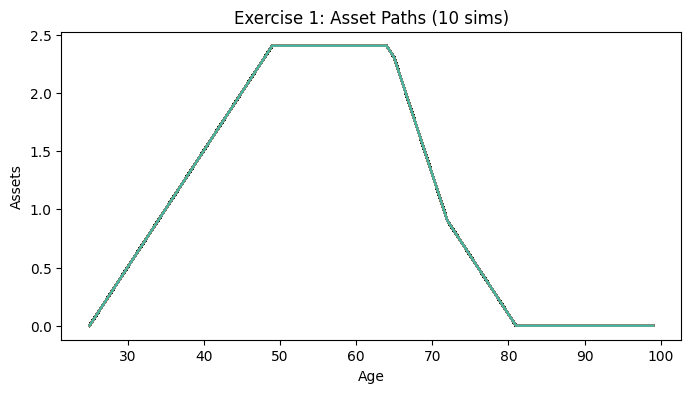

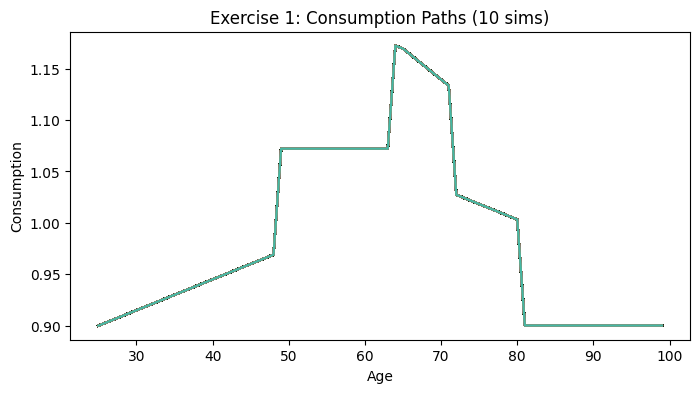

In [16]:
# plot assets
plt.figure(figsize=(8,4))
for sim in range(n_sim):
    plt.plot(s_grid+24, paths_a[sim,1:], alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Assets")
plt.title("Exercise 1: Asset Paths (10 sims)")
plt.show()

# plot consumption
plt.figure(figsize=(8,4))
for sim in range(n_sim):
    plt.plot(s_grid+24, paths_c[sim,1:], alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Consumption")
plt.title("Exercise 1: Consumption Paths (10 sims)")
plt.show()


## 5. Exercise 2: Stochastic Income

Now $z_t = \kappa(s) + e_t$ with  
$$
\kappa(s)=\tfrac23 + \tfrac3{100}s - \tfrac1{2000}s^2
$$
and $\ln e_t = \rho\ln e_{t-1} + \varepsilon_t,\ \varepsilon_t\sim N(0,\sigma^2_e)$.


In [17]:
# %%
ρ = 0.92
σ_e = np.sqrt(0.04)

# kappa(s)
kappa = (2/3) + 3/100*s_grid - 1/2000*s_grid**2

# discretize AR(1) using Tauchen (e.g. 7 states)
def tauchen(rho, sigma_u, m=3, n=7):
    """
    Tauchen (1986) method to approximate the AR(1) process
        z_t = rho * z_{t-1} + u_t,     u_t ~ N(0, sigma_u^2)

    Args:
      rho     : AR(1) coefficient
      sigma_u : standard deviation of the error term
      m       : grid half-width in multiples of the unconditional std
      n       : number of grid points

    Returns:
      E  : (n,) array of grid points for z = ln e
      Pi : (n,n) transition matrix, Pi[i,j] = Pr{z' = E[j] | z = E[i]}
    """
    # 1) unconditional std of z
    sigma_z = sigma_u / np.sqrt(1 - rho**2)

    # 2) grid limits and points
    z_max =  m * sigma_z
    z_min = -m * sigma_z
    E = np.linspace(z_min, z_max, n)
    step = (z_max - z_min) / (n - 1)

    # 3) build transition matrix
    Pi = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                Pi[i, j] = norm.cdf((E[0] - rho*E[i] + step/2) / sigma_u)
            elif j == n-1:
                Pi[i, j] = 1 - norm.cdf((E[-1] - rho*E[i] - step/2) / sigma_u)
            else:
                upper = (E[j] - rho*E[i] + step/2) / sigma_u
                lower = (E[j] - rho*E[i] - step/2) / sigma_u
                Pi[i, j] = norm.cdf(upper) - norm.cdf(lower)

    return E, Pi

ρ = 0.92
σ_e = np.sqrt(0.04)
E, Pi = tauchen(ρ, σ_e, m=3, n=7)

### 5.1. VFI with Income Shocks

State = $(s, e_{idx}, a_{idx})$.  We solve similarly but loop over e‐states.


In [18]:
# number of income‐shock states
nE = len(E)

# number of asset grid points (if not already set)
nA = len(agrid)


# initialize V_next[e, a] at terminal age S
V_next = np.zeros((nE, nA))
for ie in range(nE):
    for ia, a in enumerate(agrid):
        c = (1+r)*a + kappa[-1] + np.exp(E[ie])
        V_next[ie, ia] = u(c)

# storage
policy_a2 = np.zeros((S+1, nE, nA))
policy_c2 = np.zeros((S+1, nE, nA))

for s in range(S, 0, -1):
    V_curr = np.zeros((nE, nA))
    for ie in range(nE):
        y = kappa[s-1] + np.exp(E[ie])
        for ia, a in enumerate(agrid):
            cons = y + (1+r)*a - agrid
            util = np.array([u(c) for c in cons])
            EV = np.dot(Pi[ie,:], V_next)     # expectation over e'
            val = util + (1-xi(s))*β * EV
            j = np.nanargmax(val)
            policy_a2[s, ie, ia] = agrid[j]
            policy_c2[s, ie, ia] = cons[j]
            V_curr[ie, ia]      = val[j]
    V_next = V_curr.copy()


### 5.2. Simulate 10 Paths with Shocks


In [19]:
# %%
rng = np.random.default_rng(12345)
paths_a2 = np.zeros((n_sim, S+1))
paths_c2 = np.zeros((n_sim, S+1))

for sim in range(n_sim):
    e_idx = nE//2     # start at mean
    a = 0.0
    for s in range(1, S+1):
        ie = e_idx
        ia = np.searchsorted(agrid, a)
        c = policy_c2[s, ie, ia]
        paths_a2[sim, s] = a
        paths_c2[sim, s] = c
        a = policy_a2[s, ie, ia]
        # draw next shock
        e_idx = rng.choice(nE, p=Pi[ie])


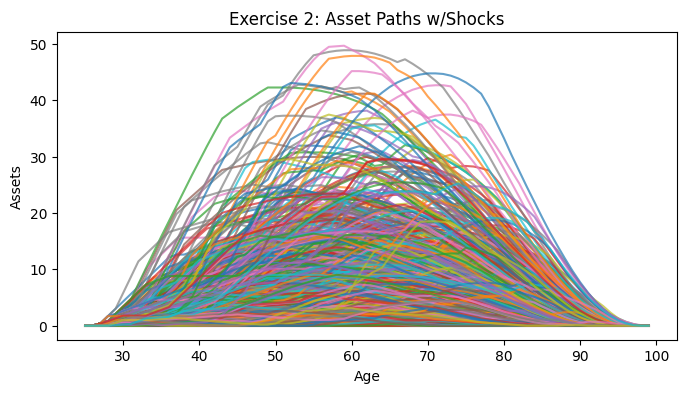

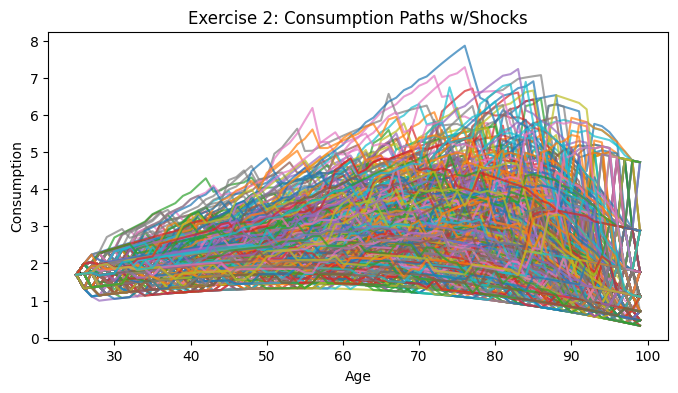

In [20]:
# plot assets stochastic
plt.figure(figsize=(8,4))
for sim in range(n_sim):
    plt.plot(s_grid+24, paths_a2[sim,1:], alpha=0.7)
plt.xlabel("Age"); plt.ylabel("Assets")
plt.title("Exercise 2: Asset Paths w/Shocks")
plt.show()

# plot consumption stochastic
plt.figure(figsize=(8,4))
for sim in range(n_sim):
    plt.plot(s_grid+24, paths_c2[sim,1:], alpha=0.7)
plt.xlabel("Age"); plt.ylabel("Consumption")
plt.title("Exercise 2: Consumption Paths w/Shocks")
plt.show()


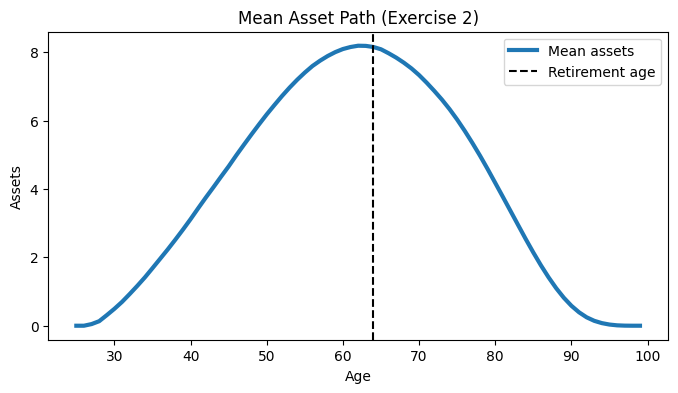

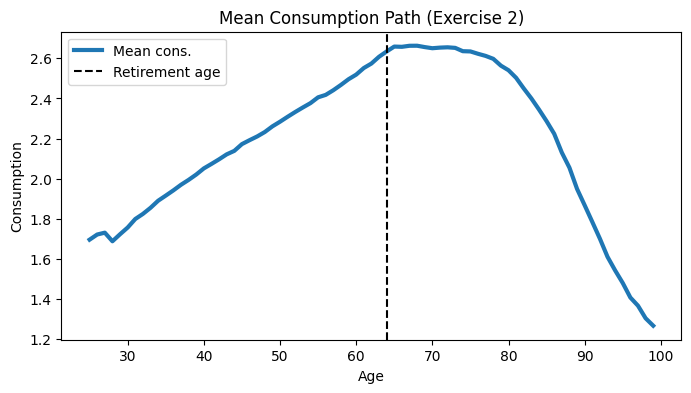

In [21]:
# after your simulation block
mean_a = paths_a2[:,1:].mean(axis=0)
mean_c = paths_c2[:,1:].mean(axis=0)

plt.figure(figsize=(8,4))
plt.plot(s_grid+24, mean_a, lw=3, label="Mean assets")
plt.axvline(24+T_work, color="k", ls="--", label="Retirement age")
plt.xlabel("Age"); plt.ylabel("Assets")
plt.title("Mean Asset Path (Exercise 2)")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(s_grid+24, mean_c, lw=3, label="Mean cons.")
plt.axvline(24+T_work, color="k", ls="--", label="Retirement age")
plt.xlabel("Age"); plt.ylabel("Consumption")
plt.title("Mean Consumption Path (Exercise 2)")
plt.legend()
plt.show()
